# Imports

In [39]:
! pip install pyod

In [40]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# Load data

Dataset Reference: https://www.kaggle.com/datasets/uciml/forest-cover-type-dataset/data

In [41]:
# Load the .mat file
file_path = '/content/drive/MyDrive/Dataset/cover.mat'  # Update with the correct path to your .mat file
mat_contents = scipy.io.loadmat(file_path)

# Inspect the contents to find the key containing the data
print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [42]:
# Assume the main data is under a key named 'data' (you need to update this based on actual contents)
data_key = 'X'  # Update this with the correct key
data = mat_contents[data_key]

# Target value
target_key = 'y'
target = mat_contents[target_key]

# Convert the target array to integers
target = target.astype(int)

In [43]:
# If the data is a structured array, convert it directly to a DataFrame
dataframe = pd.DataFrame(data)
dataframe.columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                     'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                     'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                     'Horizontal_Distance_To_Fire_Points']

dataframe['Class'] = target

dataframe.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Class
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


# Analysis & Formating

In [44]:
dataframe.Class.value_counts()

Class
0    283301
1      2747
Name: count, dtype: int64

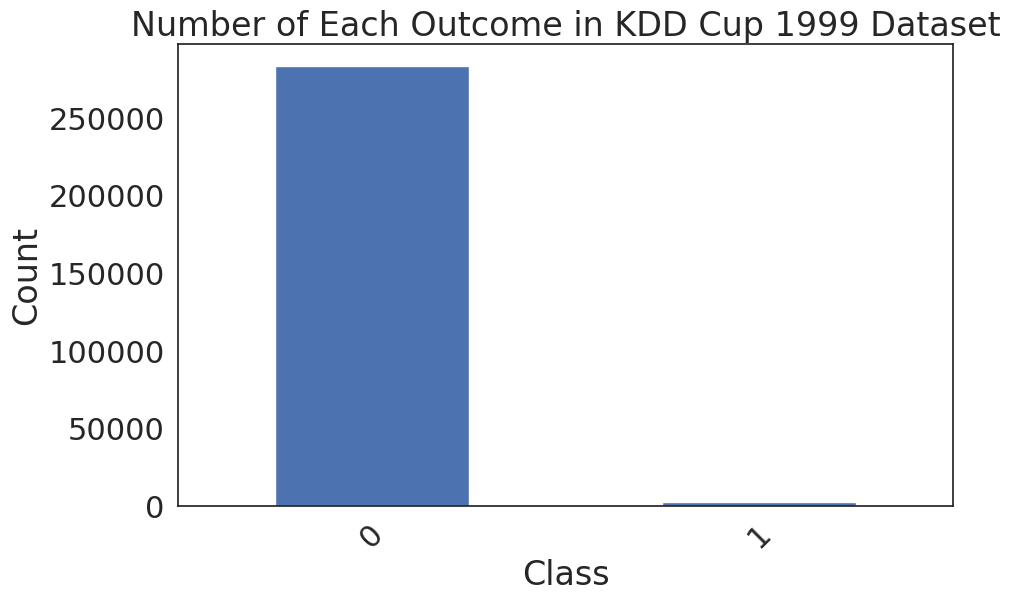

In [45]:
# Draw a graph showing the distribution of class
outcome_counts = dataframe['Class'].value_counts()

plt.figure(figsize=(10, 6))
outcome_counts.plot(kind='bar')
plt.title('Number of Each Outcome in KDD Cup 1999 Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [46]:
## separate the Fraud and the Normal dataset for future reference
Anomaly = dataframe[dataframe['Class'] == 1]
Normal = dataframe[dataframe['Class'] == 0]

print("Shape of Anomaly and Normal Datasets: ", Anomaly.shape, Normal.shape)

# Find the ration of Outlier to Normal
outlier_fraction = len(Anomaly)/float(len(Normal))

print("Fraction of outlier to normal: ",outlier_fraction)

Shape of Anomaly and Normal Datasets:  (2747, 11) (283301, 11)
Fraction of outlier to normal:  0.009696400648073956


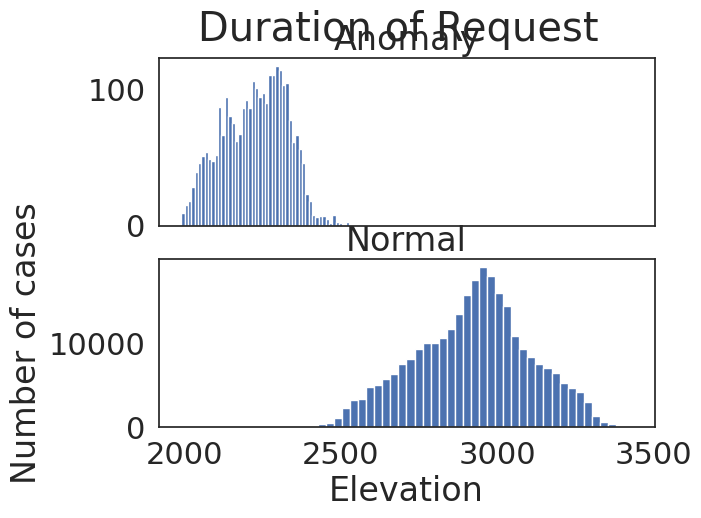

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Duration of Request')
ax1.hist(Anomaly.Elevation, bins=50)
ax1.set_title('Anomaly')
ax2.hist(Normal.Elevation, bins=50)
ax2.set_title('Normal')
plt.xlabel('Elevation')
plt.ylabel('Number of cases')
# make the y-axis unit in logarithmic scale
plt.show()

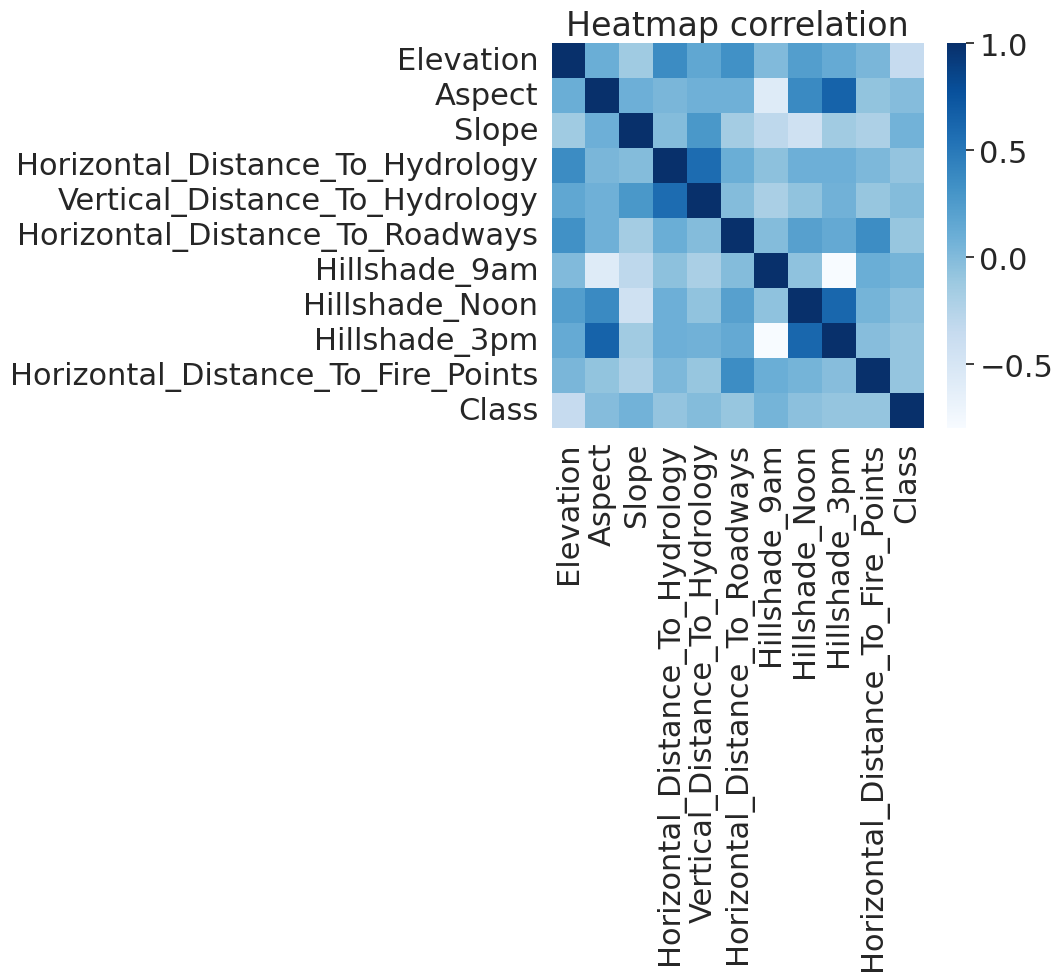

In [48]:
import seaborn

df_corr = dataframe.corr()

plt.figure(figsize=(6,5))
seaborn.heatmap(df_corr, cmap='Blues')
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

# Useful Functions

In [49]:
# When given the actual class and predicted class it plots confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Anomaly Detection

## PCA

In [50]:
df = dataframe.copy()

In [51]:
df.shape

(286048, 11)

In [52]:
# Separate the dataset into normal and anomaly
df_normal = df[df['Class'] == 0]
df_anomaly = df[df['Class'] == 1]

In [53]:
# Separate features and target variable
X = dataframe.drop('Class', axis=1)
y = dataframe['Class']

In [54]:
# Scale the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.90)  # Retain 90% of the variance
X_pca = pca.fit_transform(X_scaled)

In [56]:
# Calculate Cumulative Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

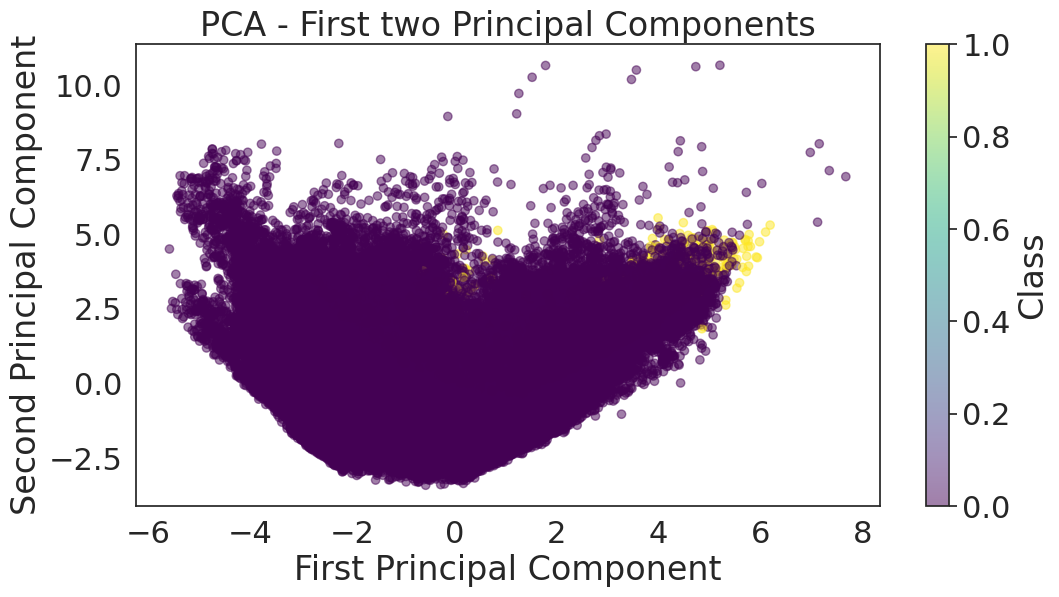

In [57]:
# Plot the first two principal components
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class')
plt.title('PCA - First two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

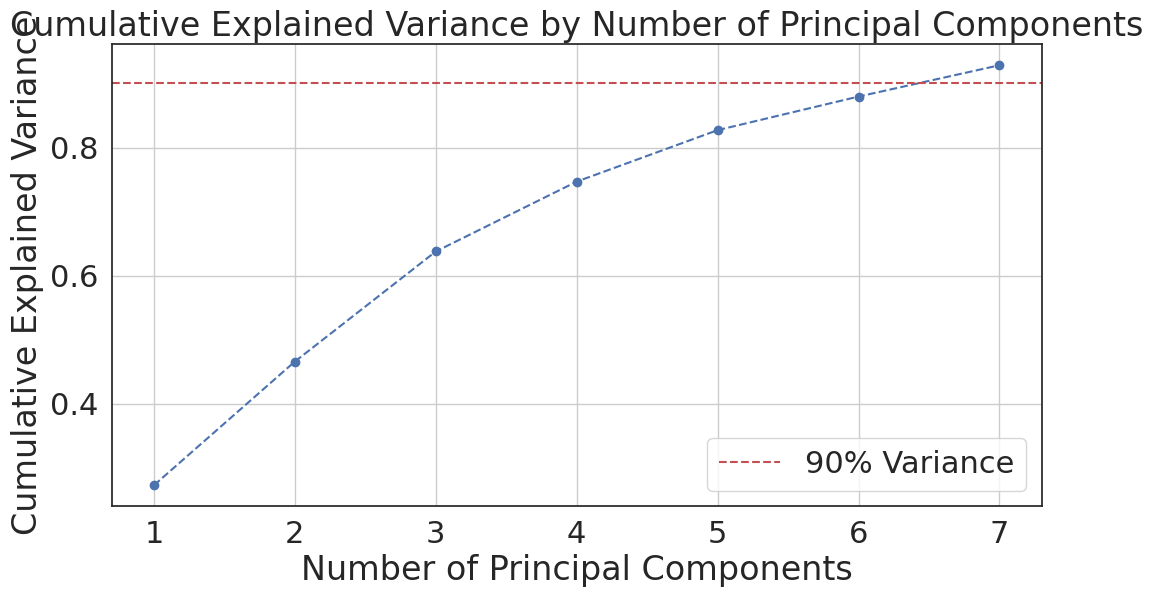

In [58]:
# Plot the cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
# Reconstruct the original data from the principal components
X_reconstructed = pca.inverse_transform(X_pca)

In [60]:
# Calculate the reconstruction error for each data point
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
reconstruction_error

array([0.02366469, 0.10933338, 0.04201978, ..., 0.00858195, 0.0021721 ,
       0.0020819 ])

In [61]:
# Determine a threshold for identifying anomalies
# For example we selected 95th percentile of the reconstruction errors
threshold = np.percentile(reconstruction_error, 99)

In [62]:
# Identify anomalies based on the reconstruction error
y_pred = (reconstruction_error > threshold).astype(int)

In [63]:
y_pred.sum()

2861

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    283301
           1       0.00      0.00      0.00      2747

    accuracy                           0.98    286048
   macro avg       0.50      0.50      0.50    286048
weighted avg       0.98      0.98      0.98    286048



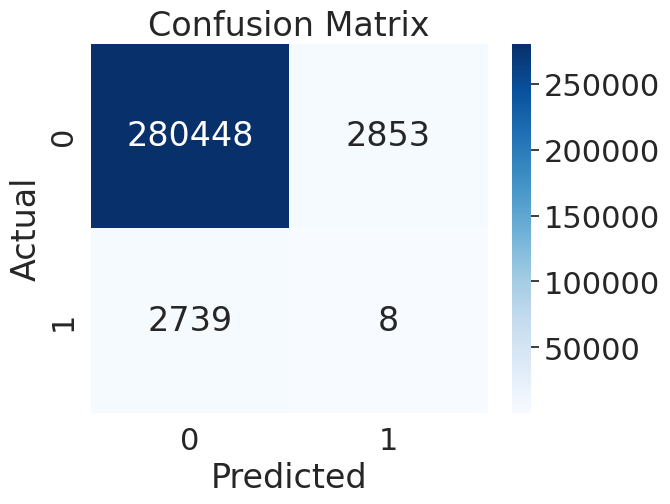

In [64]:
# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y, y_pred))
plot_confusion_matrix(y, y_pred)

pca_report = classification_report(y, y_pred, output_dict=True)

## AutoEncoder

In [65]:
df = dataframe.copy()
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Class
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


In [66]:
print("Distribuition of Normal(0) and Anomaly(1): ")
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes

Distribuition of Normal(0) and Anomaly(1): 


Class
0    283301
1      2747
Name: count, dtype: int64

In [67]:
X = df.drop('Class', axis=1)
y = df['Class']

In [68]:
# Standard Scaling for better learning

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
# First split: training + validation and test sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Second split: training and validation sets (75% train, 25% val from the 80% train+val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [70]:
print(f"train_data_normalised.shape: {X_train.shape}")
print(f"validation_data_normalised.shape: {X_test.shape}")
print(f"test_data_normalised.shape: {X_val.shape}")

train_data_normalised.shape: (171628, 10)
validation_data_normalised.shape: (57210, 10)
test_data_normalised.shape: (57210, 10)


In [71]:
# lets change the labels with boolean
train_label,validation_label, test_label = y_train.astype(bool), y_val.astype(bool), y_test.astype(bool)

In [72]:
# now  lets seperate the normal and fraud data out of training dataset
normal_train_data = X_train[~train_label] # normal transactions out of train_data_normalised
normal_test_data = X_test[~test_label] # normal transactions out of test_data_normalised
normal_validation_data = X_val[~validation_label]

print(len(normal_train_data))
print(len(normal_test_data))
print(len(normal_validation_data))

170051
56611
56639


In [73]:
fraud_train_data = X_train[train_label]
fraud_test_data = X_test[test_label]
fraud_validation_data = X_val[validation_label]

print(len(fraud_train_data))
print(len(fraud_test_data))
print(len(fraud_validation_data))

1577
599
571


Encoder Design

In [74]:
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping

In [75]:
# TODO: increase the Dropout
n_features = len(X.columns)
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.2))
encoder.add(layer=layers.Dense(units=100, activation=activations.relu))
encoder.add(layer=layers.Dense(units=10, activation=activations.relu))

Decoder Design

In [76]:
decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.relu, input_shape=[10]))
decoder.add(layer=layers.Dense(units=200, activation=activations.relu))
decoder.add(layers.Dropout(0.15))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

In [77]:
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss=losses.MSE, optimizer=optimizers.Adam(), metrics=[metrics.mean_squared_error])

In [78]:
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,restore_best_weights=True)
history = autoencoder.fit(x=normal_train_data, y=normal_train_data, epochs=100, verbose=1, validation_data=(normal_validation_data, normal_validation_data), callbacks=[es])

Epoch 1/100
5315/5315 [==============================] - 33s 6ms/step - loss: 0.5663 - mean_squared_error: 0.5663 - val_loss: 0.5492 - val_mean_squared_error: 0.5492
Epoch 2/100
5315/5315 [==============================] - 24s 5ms/step - loss: 0.5496 - mean_squared_error: 0.5496 - val_loss: 0.5471 - val_mean_squared_error: 0.5471
Epoch 3/100
5315/5315 [==============================] - 25s 5ms/step - loss: 0.5478 - mean_squared_error: 0.5478 - val_loss: 0.5465 - val_mean_squared_error: 0.5465
Epoch 4/100
5315/5315 [==============================] - 27s 5ms/step - loss: 0.5472 - mean_squared_error: 0.5472 - val_loss: 0.5467 - val_mean_squared_error: 0.5467
Epoch 5/100
5315/5315 [==============================] - 28s 5ms/step - loss: 0.5470 - mean_squared_error: 0.5470 - val_loss: 0.5468 - val_mean_squared_error: 0.5468
Epoch 6/100
5315/5315 [==============================] - 22s 4ms/step - loss: 0.5467 - mean_squared_error: 0.5467 - val_loss: 0.5462 - val_mean_squared_error: 0.5462
Epoc

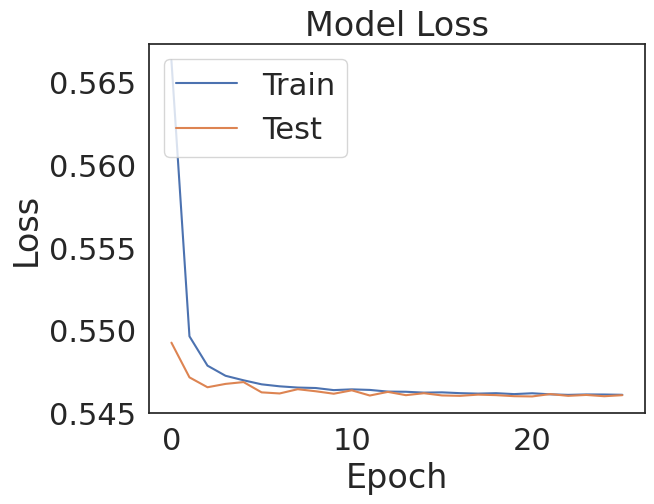

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [80]:
# Define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  dec_img = autoencoder.predict(data) # this will decode or reconstruct
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(10), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

1770/1770 [==============================] - 3s 2ms/step


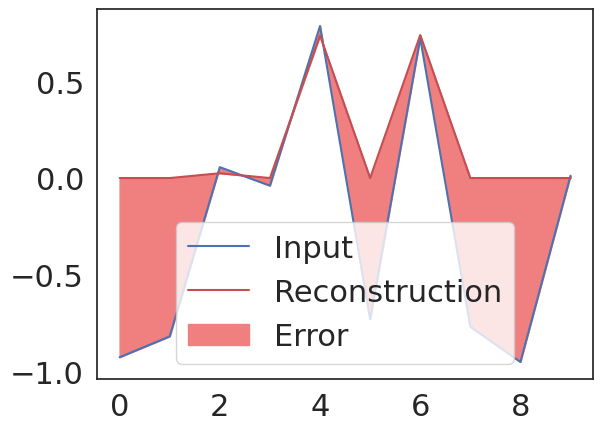

19/19 [==============================] - 0s 3ms/step


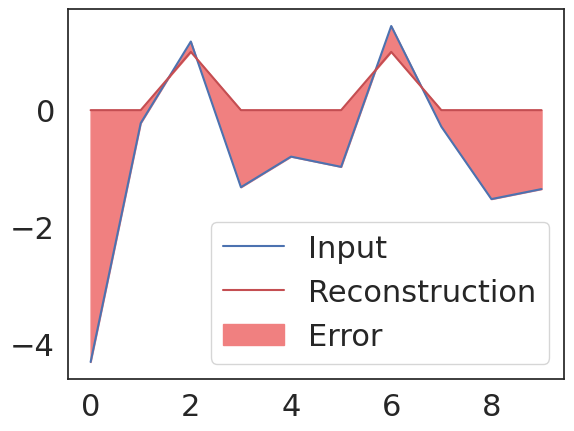

In [81]:
plot(normal_test_data, 4) # here n shows the index of ecg samples
plot(fraud_test_data, 4)

5315/5315 [==============================] - 12s 2ms/step
0.4946173665182288


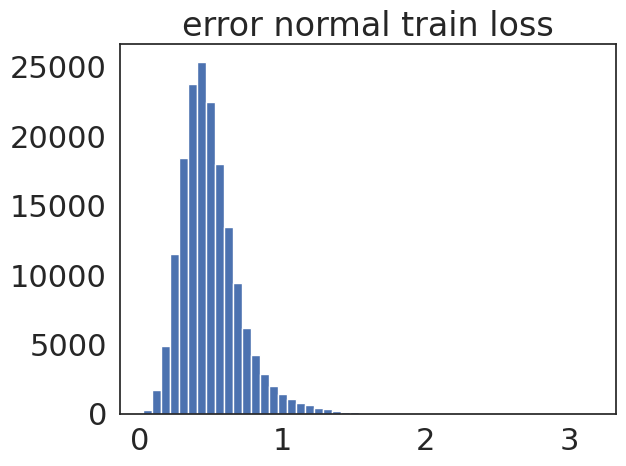

In [82]:
### calculating the train error  in legit transactions
reconstructed = autoencoder.predict(normal_train_data)
train_normal_loss = losses.mae(reconstructed, normal_train_data).numpy()
print(np.mean(train_normal_loss))

plt.hist(train_normal_loss, bins = 50)
plt.title('error normal train loss')
plt.show()

50/50 [==============================] - 0s 2ms/step
1.0243545380296797


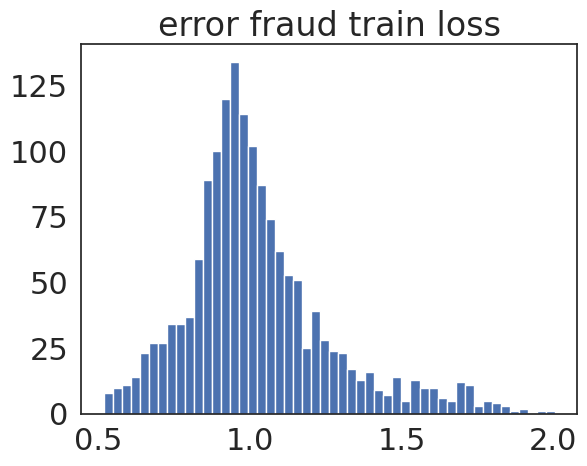

In [83]:
### calculating the train error  in fraud transactions
reconstructed = autoencoder.predict(fraud_train_data)
train_fraud_loss = losses.mae(reconstructed, fraud_train_data).numpy()
print(np.mean(train_fraud_loss))
plt.hist(train_fraud_loss, bins = 50)
plt.title('error fraud train loss')
plt.show()

In [84]:
Fraud = df.Class.sum()
total = len(df)
fraud_percentage = (Fraud/total)*100
fraud_percentage
# so lets say that 1% of transactions are fraud so lets find the threshold

0.9603283365029646

In [85]:
# calcualting the error in the whole train data
reconstructed = autoencoder.predict(X_train)
train_loss = losses.mae(reconstructed, X_train).numpy()

5364/5364 [==============================] - 11s 2ms/step


In [86]:
# we are assuming that we have 3% of fraud transaction here
cut_off_1 = np.percentile(train_loss, 99)
cut_off_1

1.2296314620222846

In [87]:
cut_off_2 = np.mean(train_loss) + 5*np.std(train_loss)
cut_off_2
# 2std division covers 97% of the distribution and here i have taken 3 std division

1.5835896506782003

In [88]:
reconstructed = autoencoder.predict(X_test)
errors = losses.mae(reconstructed, X_test)
len(errors)
predicted = []
for error in errors:
    if error > cut_off_1:
        predicted.append(1)
    else:
        predicted.append(0)

1788/1788 [==============================] - 3s 2ms/step


In [89]:
np.sort(errors)[::-1]

array([3.16387492, 2.79582904, 2.63897866, ..., 0.02984031, 0.02839748,
       0.0280808 ])

In [90]:
predicted_fraud_cases = np.array(predicted).sum()
actual_fraud_cases = test_label.sum()
print('predicted_fruad_cases =>'.format(), predicted_fraud_cases, 'true fraud cases =>'.format(), actual_fraud_cases)

predicted_fruad_cases => 599 true fraud cases => 599


In [91]:
# From booliean Map back to 1 and 0
true_label = test_label.map({True:1,False:0})

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56611
           1       0.16      0.16      0.16       599

    accuracy                           0.98     57210
   macro avg       0.58      0.58      0.58     57210
weighted avg       0.98      0.98      0.98     57210



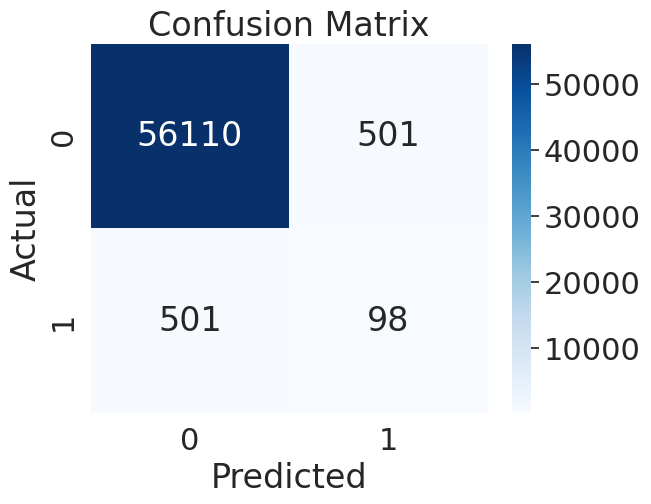

In [92]:
### classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_label, predicted))
plot_confusion_matrix(true_label, predicted)

ann_report = classification_report(true_label, predicted, output_dict=True)

##  DBSCAN

In [93]:
df = dataframe.copy()

In [94]:
# Sample the data
df = df.sample(frac=0.1, random_state=42)

In [95]:
X = df.drop('Class', axis=1)
y = df['Class']

In [96]:
# here we are going to use min max scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

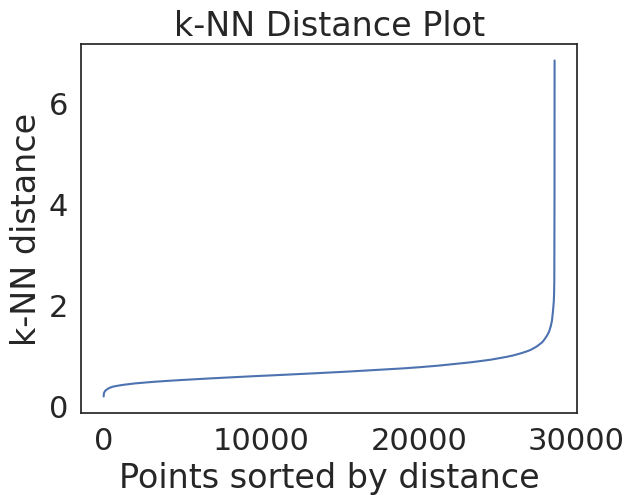

In [97]:
from sklearn.neighbors import NearestNeighbors

# Step 1: Calculate the k-nearest neighbors
k = 5  # k is usually set to min_samples - 1
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Step 2: Sort the distances (4th column)
distances = np.sort(distances[:, k-1], axis=0)

# Step 3: Plot the distances
plt.plot(distances)
plt.ylabel('k-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-NN Distance Plot')
plt.show()

# The "elbow" point is a good candidate for `eps`

In [98]:
from sklearn.cluster import DBSCAN

# Create DBSCAN object
dbscan = DBSCAN(eps=1.5, min_samples=50)

In [99]:
# Fitting the model
model = dbscan.fit(X_scaled)

In [100]:
# classification result as labels
labels = model.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [101]:
# Find unique values
unique_values = np.unique(labels)

# Print unique values
print(unique_values)

[-1  0]


In [102]:
# Consider all nodes belonging to -1 as outliers
outlier_indices = np.where(labels == -1)[0]
print(len(outlier_indices))

1520


In [103]:
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
prediction = np.where(labels == -1, 1, 0)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     28314
           1       0.10      0.51      0.16       291

    accuracy                           0.95     28605
   macro avg       0.55      0.73      0.57     28605
weighted avg       0.99      0.95      0.96     28605



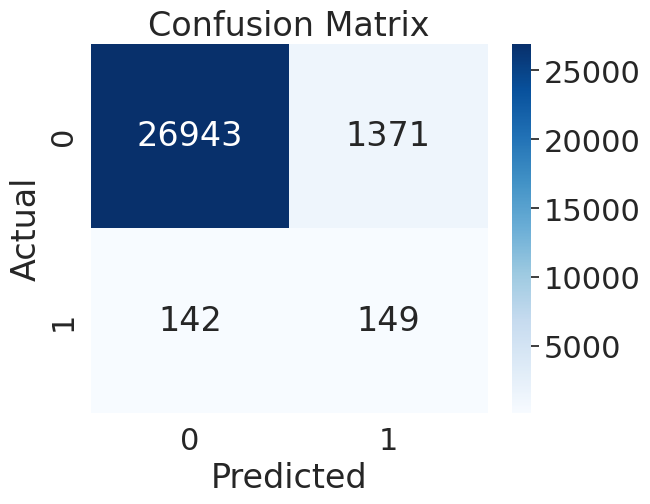

In [104]:
### classification report
print(classification_report(y, prediction))
plot_confusion_matrix(y, prediction)

dbscan_report = classification_report(y, prediction, output_dict=True)

## GMM

In [105]:
df = dataframe.copy()

In [106]:
# Sample the data
df = df.sample(frac=0.1, random_state=42)

In [107]:
# Count anonalies (outlier_label = 1)
num_fraudulent = df['Class'].value_counts().get(1, 0)

# Count normal vales (outlier_label = 0)
num_normal = df['Class'].value_counts().get(0, 0)

# Calculate the ratio
if num_normal > 0:
    ratio = num_fraudulent / num_normal
else:
    ratio = float('inf')  # Avoid division by zero if there are no normal transactions

print(f'Number of fraudulent transactions: {num_fraudulent}')
print(f'Number of normal transactions: {num_normal}')
print(f'Ratio of fraudulent to normal transactions: {ratio: f}')

Number of fraudulent transactions: 291
Number of normal transactions: 28314
Ratio of fraudulent to normal transactions:  0.010278


In [108]:
y = df['Class']
X = df.drop(['Class'], axis=1)

# Only include normal data
X_normal = Normal.drop(['Class'], axis=1)
Y_normal = Anomaly.drop(['Class'], axis=1)

In [109]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [110]:
# # Split the data into test and validation sets with a 50-50 split
# X_test, X_validate, y_test, y_validate = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)
# print("Shape of X_validate:", X_validate.shape)
# print("Shape of y_validate:", y_validate.shape)

In [111]:
from sklearn.mixture import GaussianMixture

# Define the range for n_components
n_components_range = range(1, 11)

# Lists to store the BIC and AIC scores
bic_scores = []
aic_scores = []

# Fit GMM for each n_components and calculate BIC and AIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, n_init=5, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

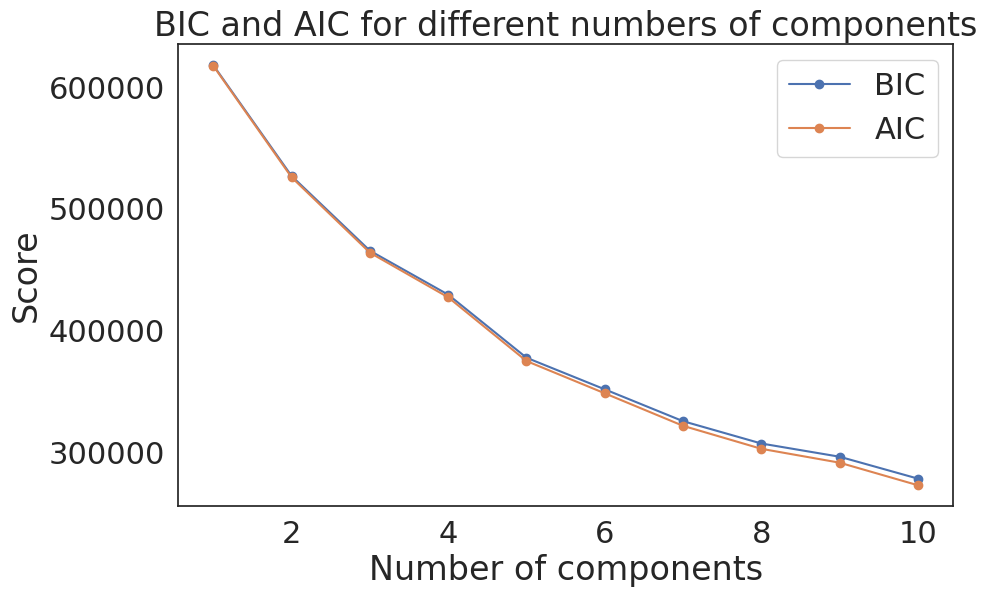

In [112]:
# Plot BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('BIC and AIC for different numbers of components')
plt.legend()
plt.show()

In [113]:
# Fit GMM model
gmm = GaussianMixture(n_components=10, n_init=10, random_state=42)
gmm.fit(X_scaled)

GaussianMixture(n_components=10, n_init=10, random_state=42)

In [114]:
score_for_normal = gmm.score_samples(X_scaled)

In [115]:
# Compute scores
y_predict = gmm.predict(X_scaled)
score = gmm.score_samples(X_scaled)
X['score'] = score
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,score
145014,2634,25,20,366,148,774,206,192,116,466,-3.844047
36438,2939,328,7,175,42,3653,203,232,168,4755,-1.763924
35638,3001,307,7,942,108,5851,201,236,175,6120,-11.041025
266449,3262,359,14,108,16,1921,199,214,152,1839,-6.532982
79169,2731,64,14,270,91,1235,232,211,108,2173,-3.743389


In [116]:
# Determine threshold for anomalies
threshold = np.percentile(score_for_normal, 3)
print(f'The threshold of the score is {threshold:.2f}')

The threshold of the score is -14.56


In [117]:
# Assign anomaly labels based on the threshold
X['predicted_class'] = (X['score'] < threshold).astype(int)

In [118]:
len(X[X['predicted_class']==1])

859

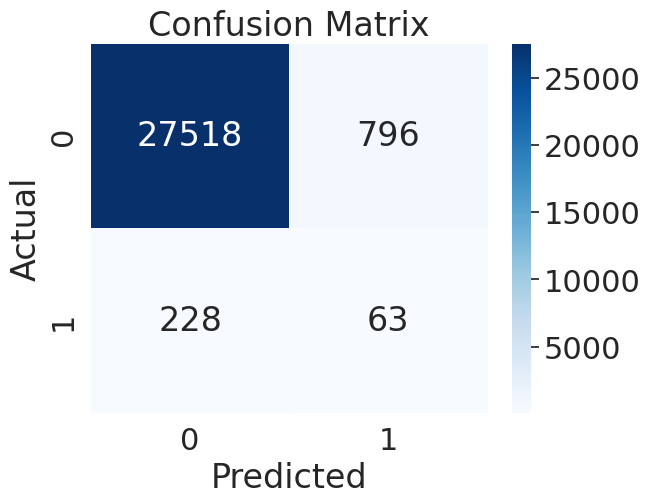

In [119]:
plot_confusion_matrix(y, X['predicted_class'])

In [120]:
# Generate classification report
class_report = classification_report(y, X['predicted_class'])
print('Classification Report:')
print(class_report)

gmm_report = classification_report(y, X['predicted_class'], output_dict=True)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     28314
           1       0.07      0.22      0.11       291

    accuracy                           0.96     28605
   macro avg       0.53      0.59      0.55     28605
weighted avg       0.98      0.96      0.97     28605



## Histogram Based Outlier Score

In [121]:
df = dataframe.copy()

In [122]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Class
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


In [123]:
# Seperate feature from target
X = df.drop('Class', axis=1)
y = df['Class']

In [124]:
# Scale the feature value
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [125]:
from pyod.models.hbos import HBOS

# Initialize HBOS
hbos = HBOS(contamination=outlier_fraction, n_bins=20)

# Fit HBOS to the data
hbos.fit(X_scaled)

HBOS(alpha=0.1, contamination=0.009696400648073956, n_bins=20, tol=0.5)

In [126]:
# Predict the outliers
y_pred = hbos.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = hbos.decision_scores_  # raw outlier scores

In [127]:
# Get the unique values and their counts
values, counts = np.unique(y_pred, return_counts=True)

# Print the count of each value
for value, count in zip(values, counts):
    print(f"Value {value} appears {count} times")

Value 0 appears 283274 times
Value 1 appears 2774 times


In [128]:
print("\nClassification Report:")
print(classification_report(y, y_pred))

hbos_report = classification_report(y, y_pred, output_dict=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    283301
           1       0.09      0.09      0.09      2747

    accuracy                           0.98    286048
   macro avg       0.54      0.54      0.54    286048
weighted avg       0.98      0.98      0.98    286048



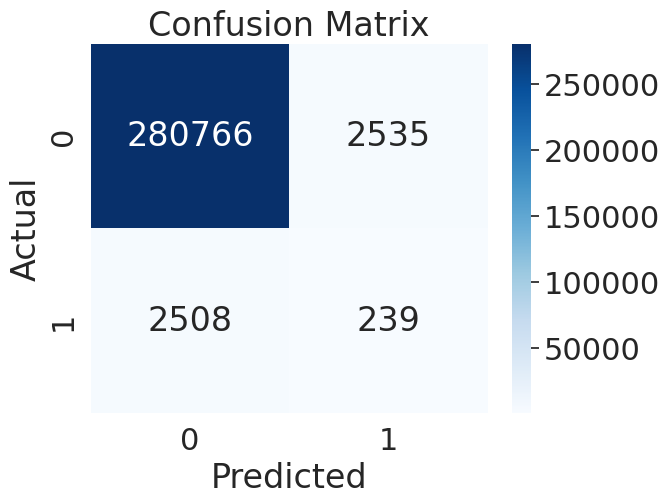

In [129]:
plot_confusion_matrix(y, y_pred)

## Isolation Forest

In [130]:
df = dataframe.copy()

In [131]:
# split train and label
x = df.drop('Class', axis = 1)
y = df['Class']

In [132]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = 0.2, random_state = 42)
x_train = Normal.drop('Class', axis = 1) # remake x_train with only normal data

In [133]:
contamintion = y_train.value_counts()[1] / len(y_train)

In [134]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=300, bootstrap=True, random_state=42, contamination=contamintion)
iforest.fit(x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(bootstrap=True, contamination=0.009386552932642307,
                n_estimators=300, random_state=42)

In [135]:
y_pred1 = iforest.predict(x_test)
y_pred1 = np.where(y_pred1 == 1, 0, 1) # normal = 1, anomaly = 0
y_pred2 = iforest.decision_function(x_test) # negative : outliers, positive : inliers

Printing the classification report with fixed parameters...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56611
           1       0.10      0.09      0.09       599

    accuracy                           0.98     57210
   macro avg       0.54      0.54      0.54     57210
weighted avg       0.98      0.98      0.98     57210

Printing the confusion matrix with fixed parameters...


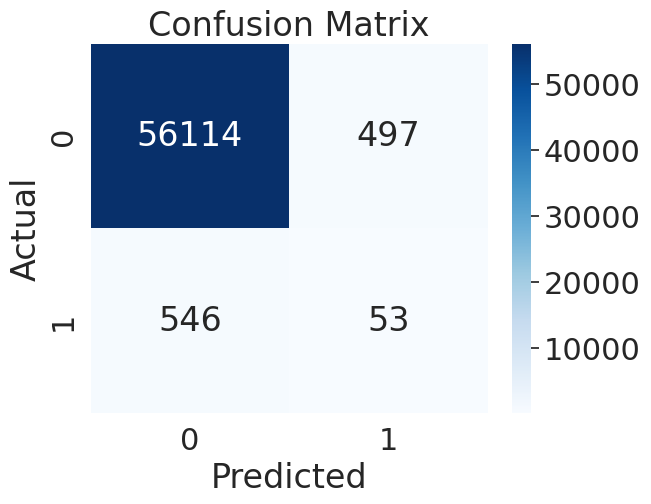

In [136]:
print("Printing the classification report with fixed parameters...")
print(classification_report(y_test, y_pred1))
print("Printing the confusion matrix with fixed parameters...")
plot_confusion_matrix(y_test, y_pred1)

if_report = classification_report(y_test, y_pred1, output_dict=True)

## KMeans

In [137]:
df = dataframe.copy()

In [138]:
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

In [139]:
# Assuming X is your original DataFrame
# Scale the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back into a DataFrame with the original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

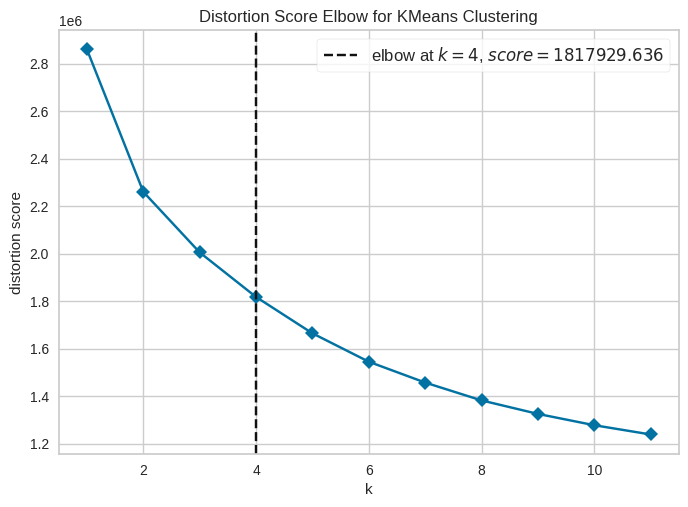

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [140]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12),  timings=False)

visualizer.fit(X_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [141]:
# Set the optimal number of clusters (based on the ElbowVisualizer output)
# optimal_clusters = visualizer.elbow_value_
optimal_clusters = 4

In [142]:
if optimal_clusters is None:
    print("No optimal number of clusters found.")
    optimal_clusters = 5
else:
    print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 4


In [143]:
# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=42)

In [144]:
# Predict clusters
clusters = kmeans.predict(X_scaled_df)

In [145]:
# Map clusters to labels by finding the majority label in each cluster
cluster_labels = {}
for cluster in range(optimal_clusters):
    mask = clusters == cluster
    majority_label = y[mask].mode()[0]  # Get the majority label
    cluster_labels[cluster] = majority_label

In [146]:
# Identify the cluster with the highest number of anomaly '1' classes
# anomaly_cluster = max(cluster_labels, key=cluster_labels.get)
anomaly_cluster = 0

In [147]:
# Generate predictions based on the identified cluster
y_pred = np.array([1 if cluster == anomaly_cluster else 0 for cluster in clusters])

<Figure size 1200x800 with 0 Axes>

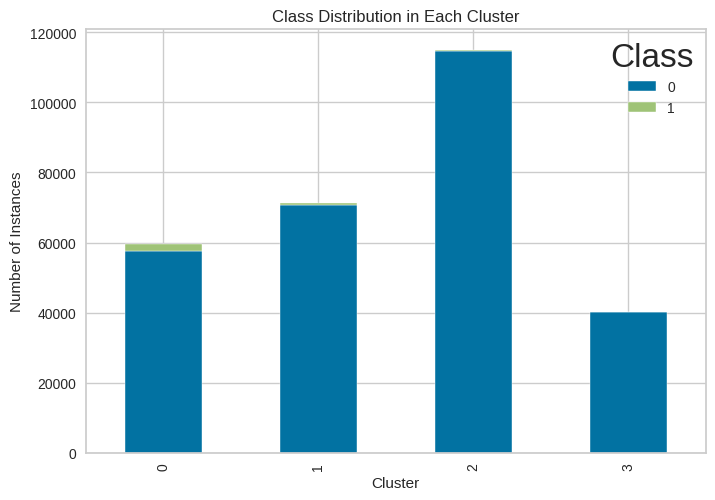

In [148]:
# Create a DataFrame for cluster and class labels
cluster_class_df = pd.DataFrame({'Cluster': clusters, 'Class': y})

# Plot class distribution in each cluster
plt.figure(figsize=(12, 8))
cluster_class_dist = cluster_class_df.groupby(['Cluster', 'Class']).size().unstack(fill_value=0)
cluster_class_dist.plot(kind='bar', stacked=True)
plt.title('Class Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Instances')
plt.legend(title='Class', loc='upper right')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.88    283301
           1       0.03      0.64      0.06      2747

    accuracy                           0.79    286048
   macro avg       0.51      0.72      0.47    286048
weighted avg       0.99      0.79      0.88    286048



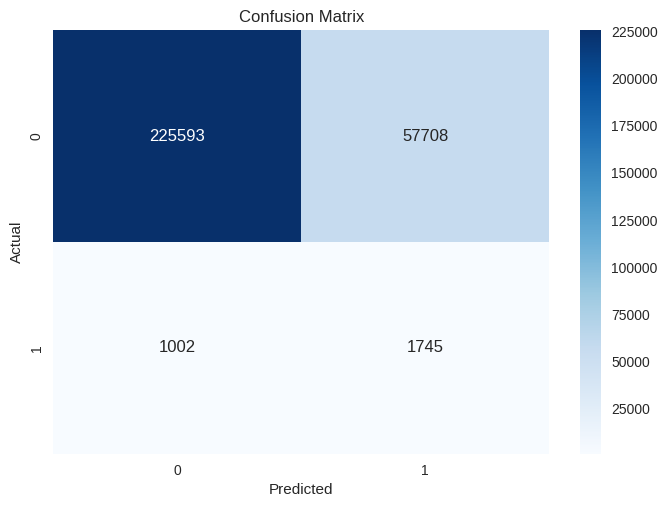

In [149]:
# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y, y_pred))
plot_confusion_matrix(y, y_pred)

km_report = classification_report(y, y_pred, output_dict=True)

## Local Otlier Factor

In [150]:
df = dataframe.copy()

In [151]:
# Seperate labels from target
X = dataframe.drop('Class', axis=1)
y = dataframe['Class']

In [152]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [153]:
from sklearn.neighbors import LocalOutlierFactor

# Works just like K-nearest neighbor so n_neighbour parameter stands for no. of neighbors we have to search for a datapoint
# contamination parameter influences how aggressively the LOF algorithm identifies outliers
LOF_classifier = LocalOutlierFactor(n_neighbors=100, algorithm='auto', metric='minkowski',
                   p=2, metric_params=None, contamination=0.05)

In [154]:
y_pred = LOF_classifier.fit_predict(X_scaled)
y_pred

array([ 1,  1, -1, ..., -1,  1, -1])

In [155]:
# Higher the lower the value(keep in my values are negative) higher the chance of it being outlier
score_prediction = LOF_classifier.negative_outlier_factor_
score_prediction

array([-1.16965595, -1.12156604, -1.32731275, ..., -1.19319054,
       -1.16767524, -1.17669248])

In [156]:
outlier_indices = np.where(y_pred == -1)[0]
print(len(outlier_indices))

14303


In [157]:
# !! CAREFUL RUN ONLY ONCE
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

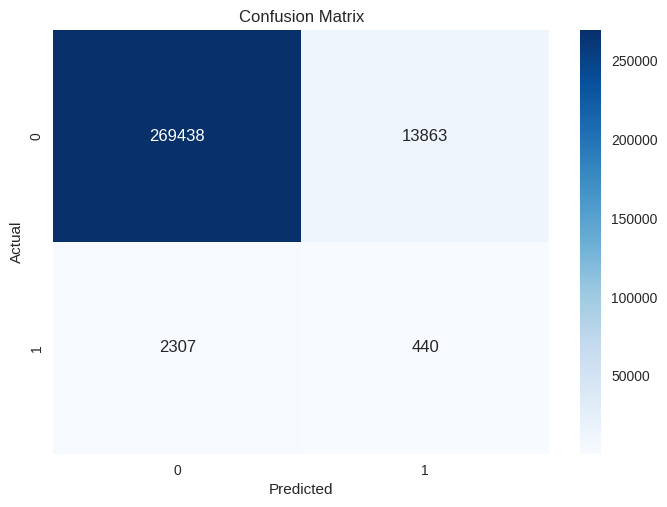

In [158]:
plot_confusion_matrix(y, y_pred)

In [159]:
print("Accuracy Score :", accuracy_score(y, y_pred))
print("Classification Report :")
print(classification_report(y, y_pred))

lof_report = classification_report(y, y_pred, output_dict=True)

Accuracy Score : 0.9434710258418167
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    283301
           1       0.03      0.16      0.05      2747

    accuracy                           0.94    286048
   macro avg       0.51      0.56      0.51    286048
weighted avg       0.98      0.94      0.96    286048



## One-Class SVM

In [160]:
df = dataframe.copy()

In [161]:
X = df.drop('Class', axis=1)
y = df['Class']

In [162]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [163]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f'There are {X_train.shape[0]} samples in the training set and {X_test.shape[0]} samples in the test set.')

There are 200233 samples in the training set and 85815 samples in the test set.


In [164]:
# Train One-Class SVM on normal transactions only
X_train_normal = X_train[y_train == 0]

In [165]:
from sklearn.svm import OneClassSVM

# Initialise OneClassSVM class
ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='auto')

In [166]:
# Fiting the data
ocsvm.fit(X_train_normal)

OneClassSVM(gamma='auto', nu=0.01)

In [167]:
# Check number of anomaly in  y test
len(y_test[y_test == 1])

877

In [168]:
# Predict on the test set
y_pred = ocsvm.predict(X_test)

In [169]:
# Map predictions to 0 for normal and 1 for anomaly to match the original labels
y_pred = [1 if x == -1 else 0 for x in y_pred]

In [170]:
anomalies_count = sum(y_pred)
print("Number of anomalies predicted:", anomalies_count)

Number of anomalies predicted: 1665


In [171]:
print("Classification Report: ")
print(classification_report(y_test, y_pred))

svm_report = classification_report(y_test, y_pred, output_dict=True)

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     84938
           1       0.47      0.90      0.62       877

    accuracy                           0.99     85815
   macro avg       0.74      0.94      0.81     85815
weighted avg       0.99      0.99      0.99     85815



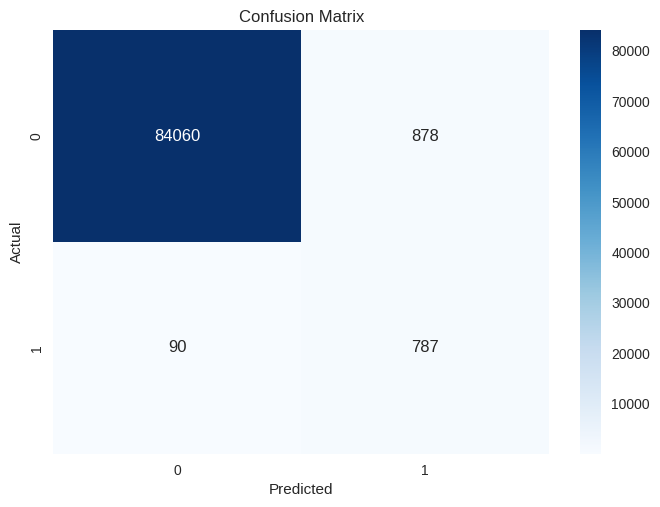

In [172]:
plot_confusion_matrix(y_test, y_pred)

## Minimum Covariance Determinant

In [173]:
df = dataframe.copy()

In [174]:
X = df.drop('Class', axis=1)
y = df['Class']

In [175]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.55681748, -0.12017323, -0.6441605 , ...,  0.68744495,
        -0.21040547,  2.78475313],
       [-0.65278338,  0.02868009,  0.61661708, ...,  0.68744495,
        -0.56655629,  2.84795653],
       [-1.69325585, -0.18529656, -1.06441969, ...,  0.63354205,
        -0.07342439,  2.72154973],
       ...,
       [-1.52657822, -1.25517981, -0.08381491, ..., -0.76793335,
        -0.12821682, -1.06152488],
       [-1.5366799 , -1.26448314,  0.05627149, ..., -0.76793335,
        -0.12821682, -1.04256386],
       [-1.54678157, -1.19935981,  0.05627149, ..., -0.87573914,
        -0.31999034, -1.02360284]])

In [176]:
from pyod.models.mcd import MCD

mcd_detector = MCD(contamination=outlier_fraction, support_fraction=1, random_state=42)

In [177]:
# Fit the model
mcd_detector.fit(X_scaled)

MCD(assume_centered=False, contamination=0.009696400648073956,
  random_state=42, store_precision=True, support_fraction=1)

In [178]:
# Get the prediction
mcd_pred = mcd_detector.predict(X_scaled)
# Get the decision scores
mcd_scores = mcd_detector.decision_scores_

In [179]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score, adjusted_rand_score, mutual_info_score, precision_recall_curve, auc
# Calculate ROC AUC
roc_auc = roc_auc_score(y, mcd_scores)
f1 = f1_score(y, mcd_pred)
ari = adjusted_rand_score(y, mcd_pred)
mi_score = mutual_info_score(y, mcd_pred)

In [180]:
print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Adjusted Rand Index:", ari)
print("Mutual Information Score:", mi_score)

ROC AUC Score: 0.9055458587310101
F1 Score: 0.04636841151965223
Adjusted Rand Index: 0.03638017202009084
Mutual Information Score: 0.0003613957743845999


              precision    recall  f1-score   support

           0       0.99      0.99      0.99    283301
           1       0.05      0.05      0.05      2747

    accuracy                           0.98    286048
   macro avg       0.52      0.52      0.52    286048
weighted avg       0.98      0.98      0.98    286048

Recall score: 0.04659628685839097


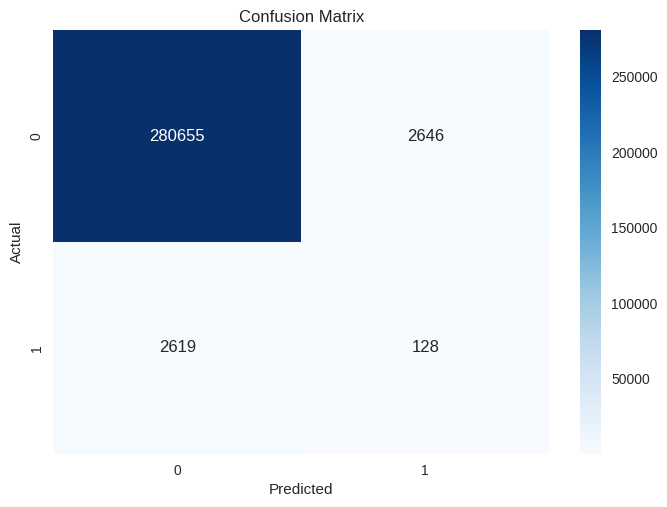

In [181]:
print(classification_report(y, mcd_pred))
print(f"Recall score: {recall_score(y, mcd_pred)}")

mcd_report = classification_report(y, mcd_pred, output_dict=True)

plot_confusion_matrix(y, mcd_pred)

Check wheather this will work with only boolean data

# CBLOF

Seperate Labels from feature value

In [182]:
df = dataframe.copy()

In [183]:
# Separate features and labels
X = df.drop(['Class'], axis=1)
y = df['Class']

Scale the feature values

In [184]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [185]:
from pyod.models.cblof import CBLOF

# Initialize the CBLOF model
cblof = CBLOF(contamination=outlier_fraction, random_state=42)

In [186]:
# Fit the model
cblof.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.009696400648073956, n_clusters=8, n_jobs=None,
   random_state=42, use_weights=False)

In [187]:
# Get the outlier scores
y_pred = cblof.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = cblof.decision_scores_  # raw outlier scores

In [188]:
len(y_pred[y_pred==1])

2774

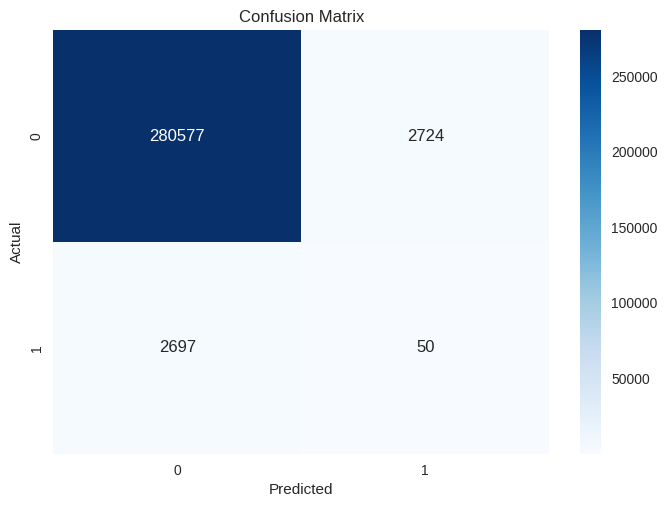

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    283301
           1       0.02      0.02      0.02      2747

    accuracy                           0.98    286048
   macro avg       0.50      0.50      0.50    286048
weighted avg       0.98      0.98      0.98    286048



In [189]:
# Evaluate the model
plot_confusion_matrix(y, y_pred)
print(classification_report(y, y_pred))

cblof_report = classification_report(y, y_pred, output_dict=True)

# Conclusion

In [190]:
# Sample reports dictionary structure
reports = {
    'Isolation Forest': if_report,
    'K-Means': km_report,
    'PCA': pca_report,
    'DBSCAN': dbscan_report,
    'ANN': ann_report,
    'GMM': gmm_report,
    'HBOS': hbos_report,
    'LOF': lof_report,
    'SVM': svm_report,
    'MCD': mcd_report,
    'CBLOF': cblof_report
}

<ipython-input-191-670f8e98ab88>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_algorithms, y=f1_scores_normal_list, ax=axes[0], palette="Blues_d")
<ipython-input-191-670f8e98ab88>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_algorithms, y=f1_scores_anomaly_list, ax=axes[1], palette="Reds_d")


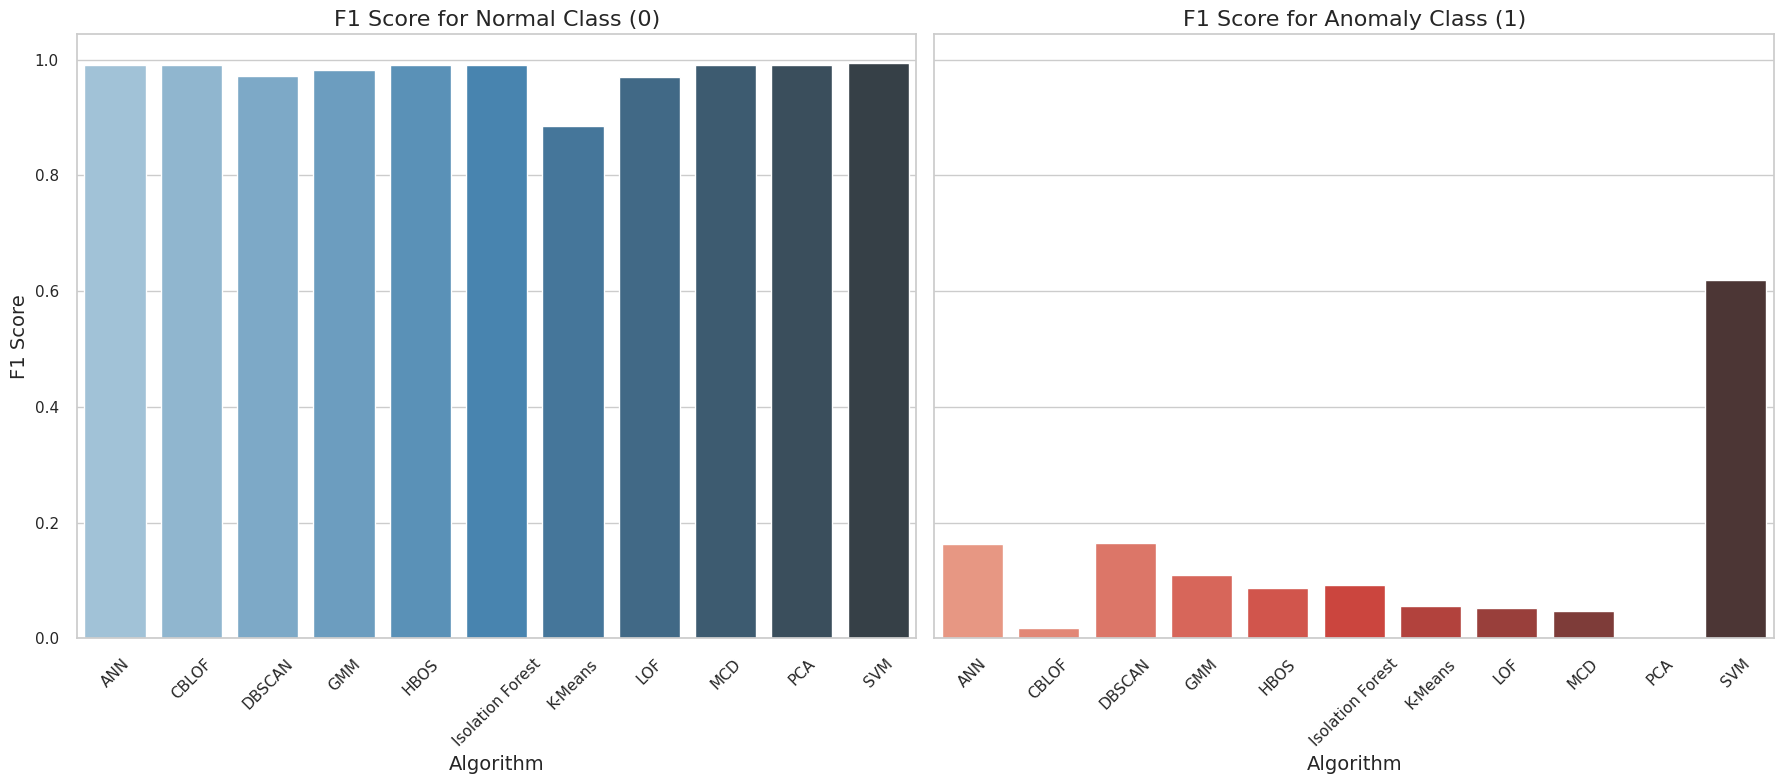

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract F1 scores for each class from the reports
f1_scores_normal = {}
f1_scores_anomaly = {}

for name, report in reports.items():
    f1_scores_normal[name] = report['0']['f1-score']
    f1_scores_anomaly[name] = report['1']['f1-score']

# Convert the extracted scores to lists of tuples sorted by algorithm name
sorted_algorithms = sorted(f1_scores_normal.keys())
f1_scores_normal_list = [f1_scores_normal[alg] for alg in sorted_algorithms]
f1_scores_anomaly_list = [f1_scores_anomaly[alg] for alg in sorted_algorithms]

# Plotting
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# Bar plot for Normal Class (0)
sns.barplot(x=sorted_algorithms, y=f1_scores_normal_list, ax=axes[0], palette="Blues_d")
axes[0].set_title('F1 Score for Normal Class (0)', fontsize=16)
axes[0].set_xlabel('Algorithm', fontsize=14)
axes[0].set_ylabel('F1 Score', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Bar plot for Anomaly Class (1)
sns.barplot(x=sorted_algorithms, y=f1_scores_anomaly_list, ax=axes[1], palette="Reds_d")
axes[1].set_title('F1 Score for Anomaly Class (1)', fontsize=16)
axes[1].set_xlabel('Algorithm', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

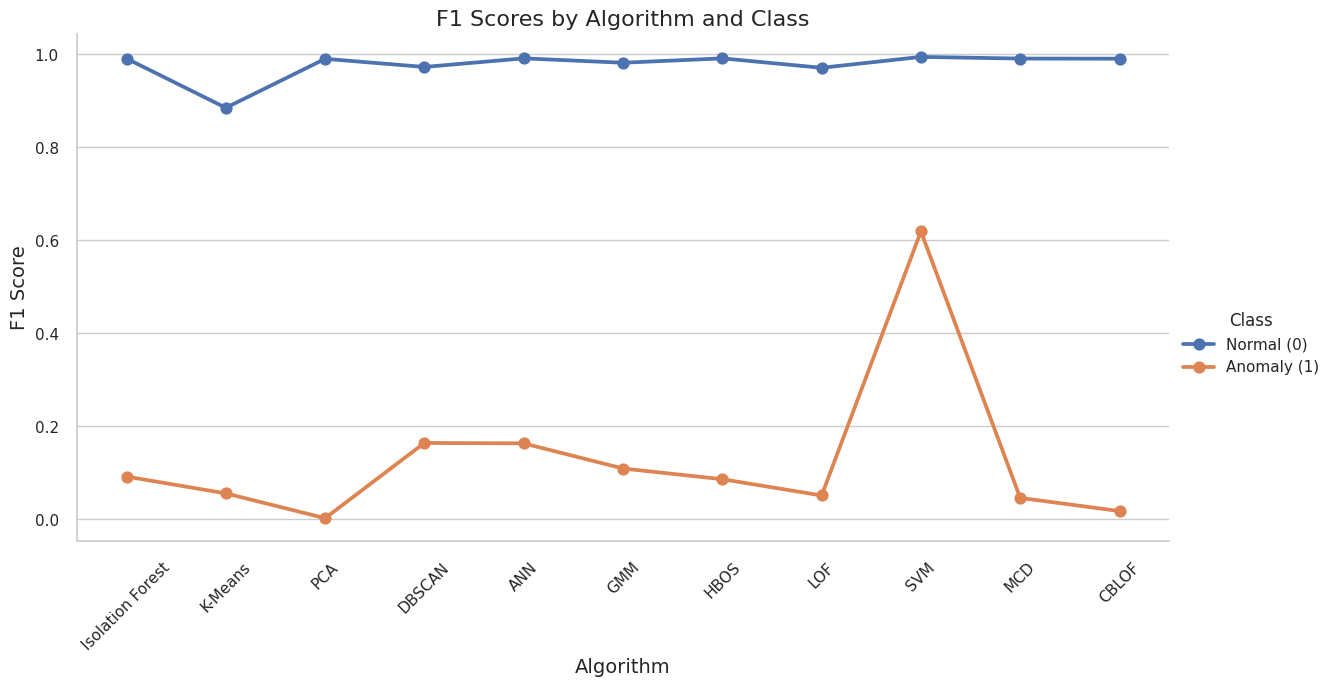

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract F1 scores for each class from the reports
data = {'Algorithm': [], 'Class': [], 'F1 Score': []}
for name, report in reports.items():
    data['Algorithm'].append(name)
    data['Class'].append('Normal (0)')
    data['F1 Score'].append(report['0']['f1-score'])
    data['Algorithm'].append(name)
    data['Class'].append('Anomaly (1)')
    data['F1 Score'].append(report['1']['f1-score'])

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))
sns.catplot(data=df, x='Algorithm', y='F1 Score', hue='Class', kind='point', height=6, aspect=2)
plt.xticks(rotation=45)
plt.title('F1 Scores by Algorithm and Class', fontsize=16)
plt.xlabel('Algorithm', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.show()
